In [5]:
# uv init
# uv venv
# uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# uv pip install numpy pandas matplotlib requests jupyterlab tiktoken

In [6]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    torch.set_default_device('cuda')
else:
    torch.set_default_device('cpu')

x = torch.randn(3, 3)
print(x.device)  # 如果有 GPU，则输出 `cuda:0`

cuda:0


In [7]:
batch_size = 4 # 训练批次
context_length = 16 # 上下文长度
d_model = 64 # 维度
num_blocks = 8 # transformer block的个数
num_heads = 4 # attension head的个数
dropout = 0.1 # dropout概率

### download traing data

In [8]:
import os
import requests

# if sales_textbook.txt not exists, download it
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [9]:
text[:100]

'Chapter 1: Building Rapport and Capturing Attention\nSubpoint: Understanding the Importance of Buildi'

### tokenize text

In [10]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text=text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long)
max_token_id = tokenized_text.max().item()

### get train_data(x_batch) and val_data(y_batch)

In [11]:
# 根据8 2的比例切分训练数据集和验证数据集
split_idx = int(len(tokenized_text) * 0.8)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

data = train_data
# 随机拿到batch_size个token开始的下标
batch_idx = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
print(batch_idx)

# 从data中取出batch_size个长度为context_length的序列，y_batch是x_batch往后偏移一位
# 下面torch.stack的作用是将list[Tensor]堆叠到一起, 有四个Tensor，每个Tensor是torch.Size([16])
x_batch = torch.stack([data[i:i+context_length] for i in batch_idx])
y_batch = torch.stack([data[i + 1:i+context_length + 1] for i in batch_idx])
print(x_batch.shape, y_batch.shape)

tensor([24445,  1131, 62232, 13566], device='cuda:0')
torch.Size([4, 16]) torch.Size([4, 16])


### initialize token embedding lookup table

In [12]:
# nn.Embedding(num_embeddings, embedding_dim), 第一个参数是可以索引的 token 数量，如果num_embeddings为10，那么索引可以是0-9。所以这里需要+1，这样才能索引到最大的那个token
token_embedding_lookup_table = nn.Embedding(max_token_id + 1, d_model)
print(token_embedding_lookup_table)

x_batch_embedding = token_embedding_lookup_table(x_batch)
y_batch_embedding = token_embedding_lookup_table(y_batch)
print(x_batch_embedding.shape, y_batch_embedding.shape) # [batch_size, context_length, d_model]

Embedding(100070, 64)
torch.Size([4, 16, 64]) torch.Size([4, 16, 64])


### initialize position encoding lookup table

1. 论文中的公式：
$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

2. 取出分母进行转化：
$$
10000^{\frac{2i}{d_{model}}} = e^{\ln(10000^{\frac{2i}{d_{model}}})} = e^{\frac{2i}{d_{model}} \ln(10000)}
$$

3. 所以：
$$
\frac{1}{10000^{\frac{2i}{d_{model}}}} = e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

4. pytorch的代码
```python
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
```

其实计算的就是：
$$
e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

5. position乘以div_term
$$
position \cdot div\_term = pos \cdot e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

$$
pos \cdot e^{-\frac{2i}{d_{model}} \ln(10000)} = e^{\ln(pos)} \cdot e^{-\frac{2i}{d_{model}} \ln(10000)}
$$
$$
= e^{\ln(pos) - \frac{2i}{d_{model}} \ln(10000)}
$$
$$
= e^{\ln\left(\frac{pos}{10000^{2i/d_{model}}}\right)}
$$
$$
= \frac{pos}{10000^{2i/d_{model}}}
$$


In [13]:
import math
# 1. 先初始化position embedding, 和我们的输入需要是一样的维度，这里是[context_length, d_model]
position_encoding_lookup_table = torch.zeros(context_length, d_model)

# 2. 拿到每个token的位置索引，本来`torch.range(0, context_length, dtype=torch.float)`计算出来是[0, 1, 2, ..., context_length]
# unsqueeze(1), 在第 1 维新增一个维度，将其形状从 [context_length] 变为 [context_length, 1]，方便后续计算
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
print("position.shape: ", position.shape)  # [context_length, 1]

# 计算div_term, 其中torch.arange(0, d_model, 2).float() ===> [0.0, 2.0, ...... 62.0]
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print("div_term.shape: ", div_term.shape)  # [d_model / 2]

# 这里做乘法的时候，会自动将 div_term 扩展为 [1, d_model / 2]，然后和 position 相乘
result = torch.sin(position * div_term) # [context_length, 1] * [1, d_model / 2] = [context_length, d_model / 2]
print("result.shape: ", result.shape)  # [context_length, d_model / 2]

# 偶数位置使用sin，奇数位置使用cos，[:, ]的意思是取所有行的所有列，但是只取偶数列或者奇数列
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)

# from [context_length, d_model] to [1, context_length, d_model]
# dim=0 添加一个维度
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0)

# 3. 将position embedding扩展到batch_size维度，from [1, context_length, d_model] to [batch_size, context_length, d_model]
# -1代表这个维度不变，直接复制上去。这里expand的意思是，有 batch_size 个相同的 position_encoding_lookup_table
# expand不会复制数据，不会占用额外的内存，适用于所有 batch 共享相同的位置编码
print(
    "position_encoding_lookup_table.shape(before expand): ",
    position_encoding_lookup_table.shape,
)
position_encoding_lookup_table = position_encoding_lookup_table.expand(batch_size, -1, -1)
print(
    "position_encoding_lookup_table.shape(after expand): ",
    position_encoding_lookup_table.shape,
)

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

position.shape:  torch.Size([16, 1])
div_term.shape:  torch.Size([32])
result.shape:  torch.Size([16, 32])
position_encoding_lookup_table.shape(before expand):  torch.Size([1, 16, 64])
position_encoding_lookup_table.shape(after expand):  torch.Size([4, 16, 64])
Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746904,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893435,-0.939824,0.341660,-0.608109,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


### add positional encoding into the input embedding vector

In [14]:
print(
    f"x_batch_embedding.shape: {x_batch_embedding.shape}, ",
    "position_encoding_lookup_table.shape: ",
    position_encoding_lookup_table.shape,
)

input_embedding_x = x_batch_embedding + position_encoding_lookup_table
print(input_embedding_x.shape) # [batch_size, context_length, d_model]

input_embedding_y = y_batch_embedding + position_encoding_lookup_table
print(input_embedding_y.shape) # [batch_size, context_length, d_model]

x_batch_embedding.shape: torch.Size([4, 16, 64]),  position_encoding_lookup_table.shape:  torch.Size([4, 16, 64])
torch.Size([4, 16, 64])
torch.Size([4, 16, 64])


### prepare Q K V (and Wq Wk Wv)

In [15]:
# 1. 将输入复制成三份，分别作为query、key、value
X = input_embedding_x
query = key = value = input_embedding_x
query.shape

Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

# 2. 然后将前面的query、key、value分别乘以Wq、Wk、Wv
Q = Wq(query)
K = Wk(key)
V = Wv(value)

print(Q.shape, K.shape, V.shape) # [batch_size, context_length, d_model]

# 3. 将Q K V拆分为多个头
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)
K = K.view(batch_size, -1, num_heads, d_model // num_heads)
V = V.view(batch_size, -1, num_heads, d_model // num_heads)

# 4. 将Q K V的维度调整，使得头数在前面，方便计算
Q = Q.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]
K = K.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]
V = V.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]

print(Q.shape, K.shape, V.shape) # [batch_size, num_heads, context_length, d_model // num_heads]

torch.Size([4, 16, 64]) torch.Size([4, 16, 64]) torch.Size([4, 16, 64])
torch.Size([4, 4, 16, 16]) torch.Size([4, 4, 16, 16]) torch.Size([4, 4, 16, 16])


### calculate attention score

In [16]:
# 1. 计算Q K的点积，拿到每个token对应每个token之间的attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads)
attention_score.shape # [batch_size, num_heads, context_length, context_length]

torch.Size([4, 4, 16, 16])

### apply mask to attention score

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.256846,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.133194,-0.394937,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.204181,-0.395008,-0.733918,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.121503,-0.183590,-0.781671,-0.396339,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,-0.041682,-0.019038,-0.339773,-0.027338,-0.192257,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.289904,-0.616908,-0.823761,-0.412821,-0.053161,0.309252,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.249917,-0.383301,0.042735,-0.441397,-0.038320,-0.244103,-0.204906,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.114429,-0.300698,0.081240,-0.155659,0.051976,-0.001437,-0.002270,0.146671,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.215526,-0.528329,-0.397534,-0.090106,-0.140383,0.015982,-0.053940,0.490714,-0.318657,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.590363,-0.152983,0.010811,0.004651,1.050351,0.916152,-0.010735,0.370383,0.232852,-0.228577,-inf,-inf,-inf,-inf,-inf,-inf


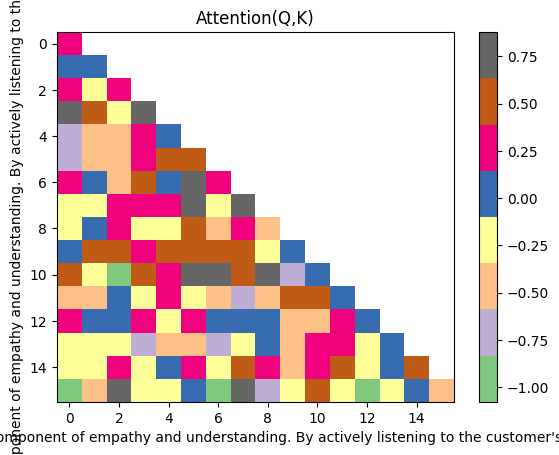

In [17]:
# 把attension score上半个三角矩阵变成-inf，这样softmax之后，这些位置的值就会变成0
# diagonal为是否包含对角线, diagonal为0, 代表包含对角线
mask = torch.triu(torch.ones_like(attention_score, dtype=torch.bool), diagonal=1)

attention_score = attention_score.masked_fill(mask, -float('inf')) # [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

### apply softmax to attention score

In [18]:
attention_score = torch.softmax(attention_score, dim=-1)
# 代表第一个batch的第一个head的维度：
print(attention_score[0][0].shape)
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

torch.Size([16, 16])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.565065,0.434935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.414073,0.342138,0.243789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.365211,0.269181,0.148013,0.217595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.215527,0.220463,0.159971,0.218640,0.185399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.159250,0.114832,0.093374,0.140830,0.201788,0.289927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.136456,0.119417,0.182848,0.112677,0.168612,0.137252,0.142739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.139986,0.092426,0.135416,0.106853,0.131510,0.124670,0.124567,0.144572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.098611,0.072123,0.082201,0.111787,0.106306,0.124299,0.115904,0.199820,0.088948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.124183,0.059052,0.069561,0.069134,0.196713,0.172009,0.068078,0.099661,0.086856,0.054752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### calculate the V attension output

In [19]:
# QK相乘，经过mask+softmax后，最后再乘以V得到A
A = torch.matmul(attention_score, V)

### concatenate attention output

In [20]:
print(A.shape) # [batch_size, num_heads, context_length, d_model // num_heads]
A = A.transpose(1, 2) # [batch_size, context_length, num_heads, d_model // num_heads]
print(A.shape)

# 现在一个multi-head attention的输出是[batch_size, context_length, num_heads, d_model // num_heads]，我们需要将其拼接起来
# 将最后两个维度拼接起来（之前是按照num_heads拆分为了多个头，现在把结果拼接回去）
A = A.reshape(batch_size, -1, d_model)
print(A.shape) # [batch_size, context_length, d_model]

torch.Size([4, 4, 16, 16])
torch.Size([4, 16, 4, 16])
torch.Size([4, 16, 64])


### define output weight matrix

In [21]:
# 最后再经过一个Wo的output权重矩阵乘法，得到最终的输出
Wo = nn.Linear(d_model, d_model)
output = Wo(A)
print(output.shape) # [batch_size, context_length, d_model]

torch.Size([4, 16, 64])


### residual connection

In [22]:
# 然后是经过残差连接
output = output + X

### layer normalization

In [23]:
# 然后经过一个层归一化
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)
output_layernorm.shape

torch.Size([4, 16, 64])

### Define Feed Forward Network

In [24]:
# 然后经过一个Feed Forward network，论文中提到由这由两个线性变换组成，中间有一个 ReLU 激活函数。线性变换的维度是 d_model(512) -> d_ff(2048) -> d_model
ffn = nn.Sequential(
    nn.Linear(in_features=d_model, out_features=d_model * 4),
    nn.ReLU(),
    nn.Linear(in_features=d_model * 4, out_features=d_model),
    nn.Dropout(dropout)
)
output_ffn = ffn(output_layernorm)

### residual connection and layerNorm again

In [25]:
# 经过feed forward network之后，又是残差连接 + 层归一化
output_ffn = output_ffn + output_layernorm
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output_ffn)
print(output.shape)

torch.Size([4, 16, 64])


### apply transformer block num_layers times

In [26]:
# 前面所有的的流程就是一个block, 要循环num_blocks次. 这里省略掉，不循环了

### apply linear layer and softmax to get logits

In [27]:
# 所有的transformer block都完成后，还有一个线性层，将d_model维度的输出转换为vocab_size维度，这样就可以预测下一个token了。max_token_id + 1是确保是可以取到下标为max_token_id的token的概率
logits = nn.Linear(d_model, max_token_id + 1)(output)  # [content_length, max_token_id + 1]
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.540941,-0.613815,0.652656,-0.049568,-0.372119,-0.155192,0.074777,0.907662,0.490581,-0.948491,...,0.202502,0.483017,0.830424,0.045403,1.036903,-0.033081,0.650529,0.725258,-0.199794,-0.839811
1,-0.439828,-0.233679,-0.121844,0.904000,0.081068,-0.345314,-0.165853,0.872865,-0.380613,0.172638,...,0.133922,-0.540132,1.261263,0.081377,0.117148,0.499174,0.365647,0.746989,0.882513,-1.570433
2,-0.251570,-0.398377,1.066544,0.367588,0.154050,-0.318921,0.269291,1.638344,-0.283802,0.378401,...,0.337113,0.160339,1.217224,0.136853,-0.070021,-0.040227,-0.094799,-0.314884,0.092157,-0.949425
3,-0.809760,0.029015,-0.158654,0.234319,0.621741,0.495307,0.539226,1.088740,-0.342117,-0.004046,...,0.129345,0.708854,0.208218,0.186286,1.106667,-0.216885,0.035263,1.179936,0.102458,-1.422831
4,0.424540,-0.229503,-0.976644,0.696093,0.419610,0.929607,0.605738,-0.008534,0.630559,0.501883,...,0.351241,-0.557068,-0.278937,-0.457670,-0.012549,-0.165369,0.032795,0.315505,0.724962,-1.243192
5,0.791561,-0.292919,0.155270,0.798886,-0.041295,-0.241638,0.488428,0.703209,-0.638989,1.259539,...,-0.155851,-0.742172,-0.782927,-0.221092,-0.957679,0.366327,0.752052,0.184245,0.486377,-0.747071
6,0.427035,0.085899,0.662812,1.016547,0.309206,-0.679681,-0.135486,0.278269,0.879552,0.354716,...,-0.512294,-0.890433,0.215918,-0.418764,-1.149659,0.083825,1.675012,-0.452429,0.769347,-0.546318
7,-0.082570,-0.004342,0.175749,1.114200,0.084463,-0.119133,-0.537368,-0.320076,1.176421,-0.366767,...,-0.447938,-0.539259,0.563848,-1.766896,-0.728363,0.224296,0.663504,-0.081669,-0.057286,-0.529046
8,-1.039237,0.592753,0.603092,-0.593416,0.924232,0.553497,0.631333,0.684755,0.770080,-0.574062,...,-0.103271,0.422616,0.071654,0.334387,0.881331,0.222043,0.163388,-0.438329,-0.217544,-0.421221
9,-0.120342,-0.062568,0.714684,-0.182347,0.285518,0.069374,0.440852,0.133236,-0.359964,-0.537508,...,0.572601,-0.008218,-1.281665,0.595234,0.145302,-0.802198,0.329160,-0.197495,0.521145,-1.251768


### get next token

In [28]:
# 我们把logits转换为概率分布，这样logits[-1]就是预测下一个token的概率分布了，找到最大的那个值，就是预测的token id
probabilities = torch.softmax(logits, dim=-1) # [batch_size, context_length, vocab_size]
print(probabilities.shape)

# 看看第一个batch的token的概率分布
pd.DataFrame(probabilities[0].detach().cpu().numpy())

torch.Size([4, 16, 100070])


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000005,0.000005,0.000016,0.000008,0.000006,0.000007,0.000009,0.000021,0.000014,0.000003,...,0.000010,0.000014,0.000019,0.000009,0.000024,0.000008,0.000016,0.000017,0.000007,0.000004
1,0.000005,0.000007,0.000007,0.000021,0.000009,0.000006,0.000007,0.000020,0.000006,0.000010,...,0.000010,0.000005,0.000030,0.000009,0.000010,0.000014,0.000012,0.000018,0.000020,0.000002
2,0.000007,0.000006,0.000025,0.000012,0.000010,0.000006,0.000011,0.000043,0.000006,0.000012,...,0.000012,0.000010,0.000029,0.000010,0.000008,0.000008,0.000008,0.000006,0.000009,0.000003
3,0.000004,0.000009,0.000007,0.000011,0.000016,0.000014,0.000015,0.000025,0.000006,0.000008,...,0.000010,0.000017,0.000010,0.000010,0.000026,0.000007,0.000009,0.000028,0.000009,0.000002
4,0.000013,0.000007,0.000003,0.000017,0.000013,0.000021,0.000015,0.000008,0.000016,0.000014,...,0.000012,0.000005,0.000006,0.000005,0.000008,0.000007,0.000009,0.000012,0.000017,0.000002
5,0.000019,0.000006,0.000010,0.000019,0.000008,0.000007,0.000014,0.000017,0.000004,0.000030,...,0.000007,0.000004,0.000004,0.000007,0.000003,0.000012,0.000018,0.000010,0.000014,0.000004
6,0.000013,0.000009,0.000016,0.000023,0.000012,0.000004,0.000007,0.000011,0.000020,0.000012,...,0.000005,0.000003,0.000010,0.000006,0.000003,0.000009,0.000045,0.000005,0.000018,0.000005
7,0.000008,0.000008,0.000010,0.000026,0.000009,0.000007,0.000005,0.000006,0.000027,0.000006,...,0.000005,0.000005,0.000015,0.000001,0.000004,0.000011,0.000016,0.000008,0.000008,0.000005
8,0.000003,0.000015,0.000015,0.000005,0.000021,0.000015,0.000016,0.000017,0.000018,0.000005,...,0.000008,0.000013,0.000009,0.000012,0.000020,0.000011,0.000010,0.000005,0.000007,0.000006
9,0.000007,0.000008,0.000017,0.000007,0.000011,0.000009,0.000013,0.000010,0.000006,0.000005,...,0.000015,0.000008,0.000002,0.000015,0.000010,0.000004,0.000012,0.000007,0.000014,0.000002


In [29]:
# 第一个batch的输入是：
print(encoding.decode(x_batch[0].tolist()))

# 直接使用argmax来找到概率值最大的token下标, logits是[batch_size, context_length, max_token_id + 1]，取第一个批次的窗口的最后一个token，然后调用argmax找到最大值的下标
predicted_index = torch.argmax(logits[0, -1]).item()
# 预测出来的token是：
encoding.decode([predicted_index])

 another critical component of empathy and understanding. By actively listening to the customer's responses


'200'

### reference
参考 LLM张老师仓库: https://github.com/waylandzhang/Transformer-from-scratch